In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None


from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, \
precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Helper Methods Section

In [2]:
def binary_converter(param):
    if param > 0:
        return 1
    else:
        return 0

In [3]:
def replace_negative_value(val):
    if(val < 0):
        return 0
    else:
        return val

In [4]:
def find_negative_columns_values(df):
    negative_columns = []

    for i, col in enumerate(df.columns):
        if ((df[col].dtypes != 'O') and df[col].min() < 0):
            negative_columns.append(col)
            
    return negative_columns

In [5]:
def replace_negative_values(val):
    if(val < 0):
        return 0
    else:
        return val

In [6]:
def show_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.title('ROC Curve')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')

    plt.show()

    auc_score = roc_auc_score(y_true, y_pred)

    mcc = matthews_corrcoef(y_true, y_pred.round())

    print('AUC: %.2f' %auc_score)
    print('MCC: %.2f' %mcc)

In [7]:
def show_confusion_matrix(y_test, y_pred, figsize=(4,4)):
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, cmap='RdYlBu', fmt='.0f', annot=True)
    plt.show()

In [8]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

## Loading the dataset

In [9]:
dataset = pd.read_csv('../modelo_unidade_diario_comentado.csv', encoding='ISO-8859-1', sep=';')

In [10]:
dataset['QTD_TRI_FAI'] = dataset['QTD_TRI'] + dataset['QTD_FAI']

In [11]:
dataset['HOUVE_TRI_FAI'] = dataset['QTD_TRI_FAI'].apply(binary_converter)

In [12]:
dataset.drop(['QTD_TRI', 'QTD_FAI', 'QTD_TRI_FAI'], axis=1, inplace=True)

In [13]:
len(dataset.columns)

135

### Removing Quiz Features

In [14]:
quiz_features = [var for var in dataset.iloc[:,55:134] if 'Q' in var and len(var) < 4]

In [15]:
print(list(quiz_features))

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70', 'Q71', 'Q72', 'Q73', 'Q74']


In [16]:
dataset.drop(labels=quiz_features, axis=1, inplace=True)

In [17]:
len(dataset.columns)

61

### Removing QTD_TRI_FAI

At some point this feature is highly correlated to the response variable that's why we should talk to ambev's team to undestand it better

In [18]:
dataset.drop(['QTD_FAI_15_dias_antes'], axis=1, inplace=True)

# Feature engineering

### Categorical features

In [19]:
categorical_vars = [var for var in dataset.columns if dataset[var].dtypes=='O']

print('Number of categorical variables: ', len(categorical_vars))

Number of categorical variables:  4


### Number of each different categorical category

In [20]:
for var in categorical_vars:
    print(var, dataset[var].unique(), ' categories')
    print()

Data ['01/01/2015' '02/01/2015' '03/01/2015' ... '09/11/2018' '10/11/2018'
 '11/11/2018']  categories

Unidade ['Arosuco Aromas' 'Arosuco Rolhas' 'F. A. Claras' 'F. Agudos' 'F. Aquiraz'
 'F. Camacari' 'F. Cebrasa' 'F. Contagem' 'F. Cuiaba' 'F. Curitibana'
 'F. Fonte Mata' 'F. Guarulhos' 'F. JACAREI' 'F. Jaguariuna' 'F. Jundiai'
 'F. Levedura' 'F. M.Navegantes' 'F. Malt P.Fundo' 'F. Manaus'
 'F. MARANHAO' 'F. Maues' 'F. Minas' 'F. Nova Minas' 'F. Pernambuco'
 'F. Rio Janeiro' 'F. Sapucaia' 'F. Sta.Catarina' 'F. Teresina'
 'F. Uberlandia' 'F. Vidro RJ' 'F.Ag.Claras Sul' 'F.Ponta Grossa' 'PIRAI']  categories

Cidade ['MANAUS' 'ESTANCIA' 'AGUDOS' 'AQUIRAZ' 'CAMACARI' 'ANAPOLIS' 'CONTAGEM'
 'CUIABA' 'ALMIRANTE TAMANDARE' 'JOAO PESSOA' 'GUARULHOS' 'JACAREI'
 'JAGUARIUNA' 'JUNDIAI' 'ITAPISSUMA' 'PORTO ALEGRE' 'PASSO FUNDO'
 'SAO LUIS' 'MAUES' 'JUATUBA' 'SETE LAGOAS' 'RIO DE JANEIRO'
 'SAPUCAIA DO SUL' 'LAGES' 'TERESINA' 'UBERLANDIA' 'VIAMAO' 'PONTA GROSSA'
 'PIRAI']  categories

Cidade_Clima 

Missing values

In [21]:
#Seekin' for missing values
vars_with_na = [var for var in dataset.columns if dataset[var].isnull().sum() > 1]

for var in vars_with_na:
    print(var, np.round(dataset[var].isnull().mean(), 3), '% missing values')

AVGTEMP_C 0.279 % missing values
MAXTEMP_C 0.279 % missing values
MINTEMP_C 0.279 % missing values
TOTALPRECIP_MM 0.279 % missing values


In [22]:
#'Data', 'Ano', 'Cidade', 'Cidade_Clima'
labelEncoder = LabelEncoder()
dataset['Data'] = labelEncoder.fit_transform(dataset['Data'])
dataset['Ano'] = labelEncoder.fit_transform(dataset['Ano'])
dataset['Unidade'] = labelEncoder.fit_transform(dataset['Unidade'])
dataset['Cidade'] = labelEncoder.fit_transform(dataset['Cidade'])
dataset['Cidade_Clima'] = labelEncoder.fit_transform(dataset['Cidade_Clima']) 

In [23]:
dfTempCidade = dataset.groupby('Cidade')[['MINTEMP_C','MAXTEMP_C', 'AVGTEMP_C']].mean().reset_index()

for cidade in range(len(dfTempCidade.index)):
    rowCidade = dfTempCidade[dfTempCidade.Cidade == cidade]
    replaceValues = {'MINTEMP_C': rowCidade.MINTEMP_C.values[0],
                     'MAXTEMP_C': rowCidade.MAXTEMP_C.values[0],
                     'AVGTEMP_C': rowCidade.AVGTEMP_C.values[0]}

    dataset.loc[dataset.Cidade == cidade] = dataset.loc[dataset.Cidade == cidade].fillna(replaceValues)

In [24]:
dataset['TOTALPRECIP_MM'].fillna(0, inplace=True)

### Features with negative values

In [25]:
negative_columns = find_negative_columns_values(dataset)

In [26]:
print(list(negative_columns))

['Parada_Automacao', 'Parada_Eletrica', 'Parada_HSMO', 'Parada_Instrumentacao', 'Parada_Mecanica', 'Parada_Operacional', 'Parada_Programada', 'Parada_Qualidade', 'Parada_Suprimentos', 'total_paradas', 'MINTEMP_C']


### As temperatures can have negative values we simply ignore MINTEMP_C column

In [27]:
negative_columns.remove('MINTEMP_C')

In [28]:
print(list(negative_columns))

['Parada_Automacao', 'Parada_Eletrica', 'Parada_HSMO', 'Parada_Instrumentacao', 'Parada_Mecanica', 'Parada_Operacional', 'Parada_Programada', 'Parada_Qualidade', 'Parada_Suprimentos', 'total_paradas']


In [29]:
for col in negative_columns:
    dataset[col] = dataset[col].apply(lambda x: replace_negative_values(x))

# Feature Scaling

In [30]:
scaler = MinMaxScaler() 
df_columns = dataset.columns

scaler.fit(dataset) 

df_columns = dataset.columns

df_scaled = pd.DataFrame(scaler.transform(dataset), columns=df_columns)

dataset = df_scaled.copy()

In [31]:
dataset.head()

,Data,Ano,Mes,Sem,Unidade,ID_UNIDADE,QLP,Altura,Atencao_Postural,Celular,Eletricidade,EPI,Equipamento_de_Elevacao,Espaco_Confinado,LOTO,Manuseio_de_Vidro,Piso_Molhado,PT,Quimicos,SAM,Transporte,Indefinido,Atos_inseguros_no_dia,Atos_inseguros_15_dias_antes,Atos_inseguros_30_dias_antes,Atos_inseguros_45_dias_antes,incidentes_no_dia,incidentes_em_15_dias,incidentes_em_30_dias,incidentes_em_45_dias,abordagens_positivas,abordagens_positivas_15_dias_antes,abordagens_positivas_30_dias_antes,abordagens_positivas_45_dias_antes,Turnover,Horas_Excedentes,Interjornadas,Cidade,Cidade_Clima,Volume_prod,Parada_Automacao,Parada_Eletrica,Parada_HSMO,Parada_Instrumentacao,Parada_Logistica,Parada_Mecanica,Parada_Operacional,Parada_Processo,Parada_Programada,Parada_Qualidade,Parada_Suprimentos,Parada_Utilidades,total_paradas,QTD_FAI_30_dias_antes,QTD_FAI_45_dias_antes,AVGTEMP_C,MAXTEMP_C,MINTEMP_C,TOTALPRECIP_MM,HOUVE_TRI_FAI
0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.571429,0.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.845570,0.770701,0.833753,0.025161,0.0
1,0.033333,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.571429,0.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.860759,0.798301,0.828715,0.005851,0.0
2,0.066667,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477528,0.0,0.571429,0.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.870886,0.783439,0.846348,0.003511,0.0
3,0.100000,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.571429,0.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.858228,0.781316,0.788413,0.016384,0.0
4,0.133333,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.571429,0.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.787342,0.702760,0.793451,0.035693,0.0


### Train Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(labels=['HOUVE_TRI_FAI'], axis=1), 
                                                    dataset[['HOUVE_TRI_FAI']], 
                                                    test_size=0.2, 
                                                    random_state=0)

X_train.shape, X_test.shape

((38406, 59), (9602, 59))

# Feature Selection

### Removing constant features

The code below removes all features which variance doesn’t meet some threshold (in this case, zero)

In [33]:
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

In [34]:
constant_features

['Indefinido']

In [35]:
X_train['Indefinido'].unique()

array([0.])

In [36]:
X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((38406, 58), (9602, 58))

### Removing quasi constant features
The code below removes all features which variance does not meet some threshold (in this case, almost 99%)

In [37]:
quasi_constant_feat = []
for feature in X_train.columns:

    # find the predominant value
    predominant = (X_train[feature].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate predominant feature
    if predominant > 0.98:
        quasi_constant_feat.append(feature)

len(quasi_constant_feat)

4

In [38]:
print(list(quasi_constant_feat))

['Equipamento_de_Elevacao', 'Espaco_Confinado', 'PT', 'Turnover']


In [39]:
X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((38406, 54), (9602, 54))

### Recursive Feature Elimination

In [40]:
# Importance of the features according to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

model_all_features = xgb.XGBClassifier(nthread=10, max_depth=8, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.832350


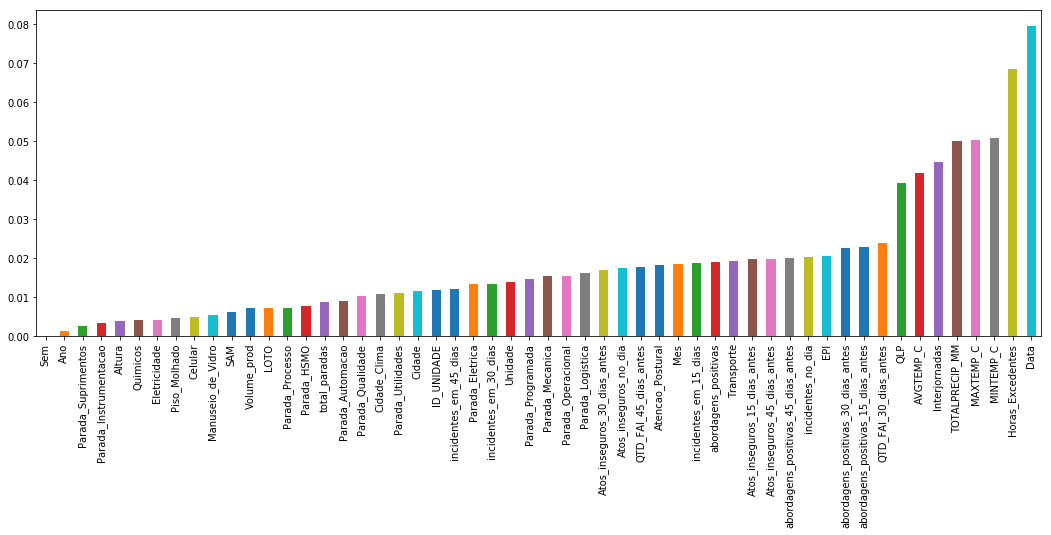

In [41]:
#  ranking each feature from the least to the most important
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

features.sort_values(ascending=True, inplace=True)

features.plot.bar(figsize=(18,6))

In [42]:
features = list(features.index)

In [43]:
# removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=8, n_estimators=500, learning_rate=0.05)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with all the features
    print('All features Test ROC AUC={}'.format((auc_score_all)))

    # determine the drop in the roc-auc
    diff_auc = auc_score_all - auc_score_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        auc_score_all = auc_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('Done')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  Sem  which is feature  1  out of  54
New Test ROC AUC=0.832349708124189
All features Test ROC AUC=0.832349708124189
Drop in ROC AUC=0.0
remove:  Sem

testing feature:  Ano  which is feature  2  out of  54
New Test ROC AUC=0.8332197149916699
All features Test ROC AUC=0.832349708124189
Drop in ROC AUC=-0.0008700068674809547
remove:  Ano

testing feature:  Parada_Suprimentos  which is feature  3  out of  54
New Test ROC AUC=0.8301474540412495
All features Test ROC AUC=0.8332197149916699
Drop in ROC AUC=0.003072260950420458
keep:  Parada_Suprimentos

testing feature:  Parada_Instrumentacao  which is feature  4  out of  54
New Test ROC AUC=0.8322873623551837
All features Test ROC AUC=0.8332197149916699
Drop in ROC AUC=0.0009323526364861667
keep:  Parada_Instrumentacao

testing feature:  Altura  which is feature  5  out of  54
New Test ROC AUC=0.833058497649596
All features Test ROC AUC=0.8332197149916699
Drop in ROC AUC=0.00016121734207

New Test ROC AUC=0.8304538299667144
All features Test ROC AUC=0.835674186049221
Drop in ROC AUC=0.005220356082506594
keep:  Atos_inseguros_45_dias_antes

testing feature:  abordagens_positivas_45_dias_antes  which is feature  41  out of  54
New Test ROC AUC=0.8343907448650545
All features Test ROC AUC=0.835674186049221
Drop in ROC AUC=0.0012834411841664561
keep:  abordagens_positivas_45_dias_antes

testing feature:  incidentes_no_dia  which is feature  42  out of  54
New Test ROC AUC=0.8309274059090564
All features Test ROC AUC=0.835674186049221
Drop in ROC AUC=0.004746780140164497
keep:  incidentes_no_dia

testing feature:  EPI  which is feature  43  out of  54
New Test ROC AUC=0.8317454579690331
All features Test ROC AUC=0.835674186049221
Drop in ROC AUC=0.003928728080187849
keep:  EPI

testing feature:  abordagens_positivas_30_dias_antes  which is feature  44  out of  54
New Test ROC AUC=0.8354918719065242
All features Test ROC AUC=0.835674186049221
Drop in ROC AUC=0.000182314142696

In [45]:
features_to_remove

['Sem',
 'Ano',
 'Altura',
 'Quimicos',
 'Manuseio_de_Vidro',
 'Parada_Utilidades',
 'abordagens_positivas_30_dias_antes']

In [46]:
X_train.drop(labels=features_to_remove, axis=1, inplace=True)
X_test.drop(labels=features_to_remove, axis=1, inplace=True)

In [47]:
len(X_train.columns)

47

### Removing features using univariate roc_auc

In [48]:
# find important features using univariate roc-auc

# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set
roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

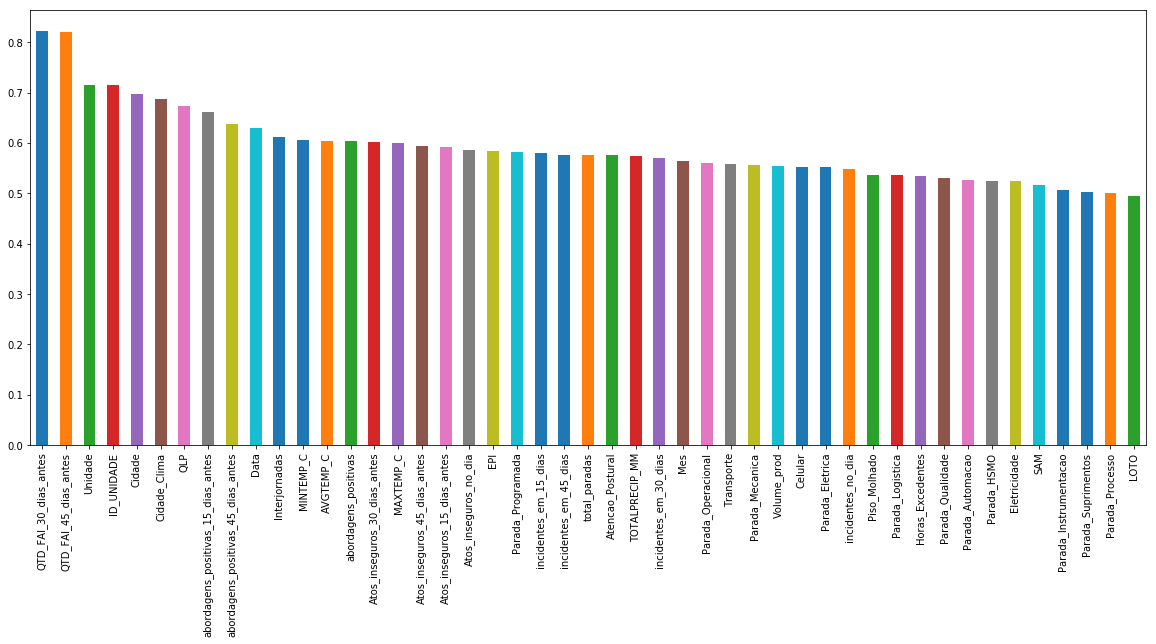

In [49]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [50]:
# by removing features with univariate roc_auc == 0.5
selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

deleted_feat = roc_values[roc_values <= 0.5]
deleted_feat

LOTO    0.49487
dtype: float64

In [51]:
X_train.drop(labels=deleted_feat.index, axis=1, inplace=True)
X_test.drop(labels=deleted_feat.index, axis=1, inplace=True)

In [52]:
len(X_train.columns)

46

### Removing correlated features

Correlation predictor variables provide redundant information

Variables should be correlated with the target but uncorrelated among themselves

In [53]:
# with the following function we can select highly correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

I chose to eliminate features under Pearson Correlation 0.8 mark

In [54]:
corr_features = correlation(X_train, 0.6)
len(set(corr_features))

20

In [55]:
print(corr_features)

{'QTD_FAI_45_dias_antes', 'MINTEMP_C', 'Atos_inseguros_45_dias_antes', 'Piso_Molhado', 'Atos_inseguros_no_dia', 'Cidade_Clima', 'Atos_inseguros_30_dias_antes', 'EPI', 'incidentes_em_30_dias', 'Cidade', 'Atos_inseguros_15_dias_antes', 'incidentes_no_dia', 'incidentes_em_45_dias', 'abordagens_positivas_45_dias_antes', 'MAXTEMP_C', 'Transporte', 'total_paradas', 'ID_UNIDADE', 'incidentes_em_15_dias', 'Volume_prod'}


In [56]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

In [57]:
len(X_train.columns)

26

Features Selected

In [60]:
X_train.columns

Index(['Data', 'Mes', 'Unidade', 'QLP', 'Atencao_Postural', 'Celular',
       'Eletricidade', 'SAM', 'abordagens_positivas',
       'abordagens_positivas_15_dias_antes', 'Horas_Excedentes',
       'Interjornadas', 'Parada_Automacao', 'Parada_Eletrica', 'Parada_HSMO',
       'Parada_Instrumentacao', 'Parada_Logistica', 'Parada_Mecanica',
       'Parada_Operacional', 'Parada_Processo', 'Parada_Programada',
       'Parada_Qualidade', 'Parada_Suprimentos', 'QTD_FAI_30_dias_antes',
       'AVGTEMP_C', 'TOTALPRECIP_MM'],
      dtype='object')

## Model Testing